In [13]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib as mpl
from importlib import reload
from vosk import Model
from Signal_Analysis.features.signal import get_HNR
from scipy import signal
from audiostretchy.stretch import stretch_audio


# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

In [14]:
import os
from librosa import load

examples_dir = "example_speech_mp3/svenska"
filenames = os.listdir(examples_dir)
print(filenames)
audios = []
for f in filenames:
    y, Fs = load(os.path.join(examples_dir, f), sr=None)
    audios.append(y)

wavfile.write("wav_examples/svenska_combo.wav", Fs, tools.stitch_frames(audios))

['common_voice_sv-SE_38528961.mp3', 'common_voice_sv-SE_38528962.mp3', 'common_voice_sv-SE_38528964.mp3', 'common_voice_sv-SE_38528967.mp3', 'common_voice_sv-SE_38528968.mp3', 'common_voice_sv-SE_38543999.mp3', 'common_voice_sv-SE_38544000.mp3', 'common_voice_sv-SE_38544001.mp3', 'common_voice_sv-SE_38544002.mp3', 'common_voice_sv-SE_38544004.mp3', 'common_voice_sv-SE_38544013.mp3', 'common_voice_sv-SE_38544014.mp3', 'common_voice_sv-SE_38544015.mp3', 'common_voice_sv-SE_38544016.mp3', 'common_voice_sv-SE_38544017.mp3', 'common_voice_sv-SE_38568655.mp3', 'common_voice_sv-SE_38568656.mp3', 'common_voice_sv-SE_38568657.mp3', 'common_voice_sv-SE_38568658.mp3', 'common_voice_sv-SE_38568659.mp3', 'common_voice_sv-SE_38568660.mp3', 'common_voice_sv-SE_38568661.mp3', 'common_voice_sv-SE_38568662.mp3', 'common_voice_sv-SE_38568663.mp3', 'common_voice_sv-SE_38568664.mp3', 'common_voice_sv-SE_38568670.mp3', 'common_voice_sv-SE_38568671.mp3', 'common_voice_sv-SE_38568672.mp3', 'common_voice_sv-SE

## preprocess

In [15]:
audio_original_path = "wav_examples/svenska_combo.wav"
_ = tools.preprocess(audio_original_path)

preprocessing svenska_combo


## Speech recognition

In [16]:
audio_path = "audio_preproc/svenska_combo_pp.wav"
Fs, audio = wavfile.read(audio_path)
model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

åter förvillande vildanden av borås låg högst på agenda utredaren ska vidare inhämta synpunkter från berörda myndigheter organisationer och näringslivsdirektörens jag har inte läst något av honom och känner honom således inte vi ska förklara de på lekman språk hon hörde här daniel talar genom dörren torrt och nyktert utan ringaste upprördhet men dagen hade angreppet av sin talang så var jag på bara det är inte alltid fallet patienten är kanske medvetslös eller alltför medtagen för att kunna ta ställning till frågan hela straffet gripa framkallar blyg ser hos den felande det i framtiden kommer allt att bli annorlunda till den här kojan har det största godset i skålen era tigga och är därtill se honom i ögonen men hon avbröt mig i det han började tala om andra men jag har i alla fall lärt mig vad som passar sig helst en knäckemackor med kaviar och ägg ja låt oss göra det tidigare hade utbildningsväsendet mot exempelvis folkbibliotek och hög skolbiblioteket ser olika ut ni måste kassa är 

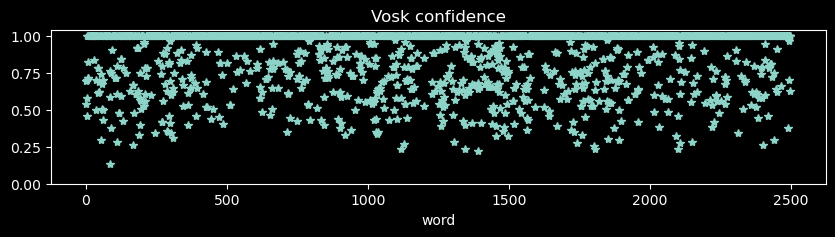

In [17]:
if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()


In [18]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 åter ['å', 'e'] 69.3943%
1 förvillande ['ö', 'i', 'a', 'e'] 54.1462%
2 vildanden ['i', 'a', 'e'] 45.8538%
3 av ['a'] 70.2828%
4 borås ['o', 'å'] 100.0%
5 låg ['å'] 58.1084%
6 högst ['ö'] 100.0%
7 på ['å'] 71.91149999999999%
8 agenda ['a', 'e', 'a'] 71.91149999999999%
9 utredaren ['u', 'e', 'a', 'e'] 82.3896%
10 ska ['a'] 100.0%
11 vidare ['i', 'a', 'e'] 100.0%
12 inhämta ['i', 'ä', 'a'] 100.0%
13 synpunkter ['y', 'u', 'e'] 100.0%
14 från ['å'] 100.0%
15 berörda ['e', 'ö', 'a'] 100.0%
16 myndigheter ['y', 'i', 'e', 'e'] 100.0%
17 organisationer ['o', 'a', 'i', 'a', 'i', 'o', 'e'] 100.0%
18 och ['o'] 100.0%
19 näringslivsdirektörens ['ä', 'i', 'i', 'i', 'e', 'ö', 'e'] 100.0%
20 jag ['a'] 100.0%
21 har ['a'] 100.0%
22 inte ['i', 'e'] 100.0%
23 läst ['ä'] 100.0%
24 något ['å', 'o'] 100.0%
25 av ['a'] 100.0%
26 honom ['o', 'o'] 100.0%
27 och ['o'] 100.0%
28 känner ['ä', 'e'] 84.1452%
29 honom ['o', 'o'] 100.0%
30 således ['å', 'e', 'e'] 100.0%
31 inte ['i', 'e'] 100.0%
32 vi ['i'] 100.0%


## test 1 word

In [19]:
def HNR_short(frames, Fs, n_peaks=-1):
    """get frame index for peaks and hnr per frame"""
    hnr_frames = np.array([get_HNR(f, Fs) for f in frames])

    min_distance = max(len(frames) / (n_peaks + 2), 1)  # frames
    peaks, peaks_prop = signal.find_peaks(
        hnr_frames,
        height=0.1 * max(hnr_frames),
        distance=min_distance,
    )
    order = (-peaks_prop["peak_heights"]).argsort()  # order
    peaks = peaks[order[:n_peaks]]  # sort and truncate
    peaks = np.sort(peaks)  # restore order
    return peaks, hnr_frames

vidare
['i', 'a', 'e']
['i', 'a', 'e']
frame length    : 640 samples
frame length    : 0.02 seconds
between frames  : 0.02 seconds
number of frames: 20


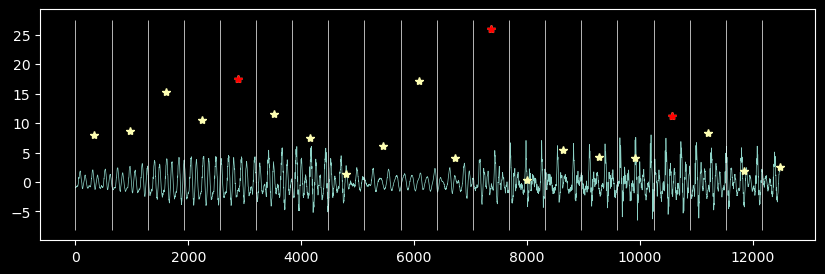

In [20]:
fl = int(0.02 * Fs)
k = 11
word = words[k]["word"]
print(word)
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
x = segments[k] / segments[k].max()
vowels = vowels_per_segment[k]

print(vowels)
print(words[k]["vowels"])

frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, vol_thr=0.1, print_info=True)

peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))

plt.figure(figsize=(10, 3))
plt.plot(8 * np.concatenate(frames))
plt.plot(f_start + int(fl / 2), hnr_frames, "*")
plt.plot(f_start[peak_frames] + int(fl / 2), hnr_frames[peak_frames], "*r")
plt.vlines(f_start, *plt.ylim())

plt.show()

wavfile.write(f"output/1word{word}.wav", Fs, tools.stitch_frames(frames[12:16]))

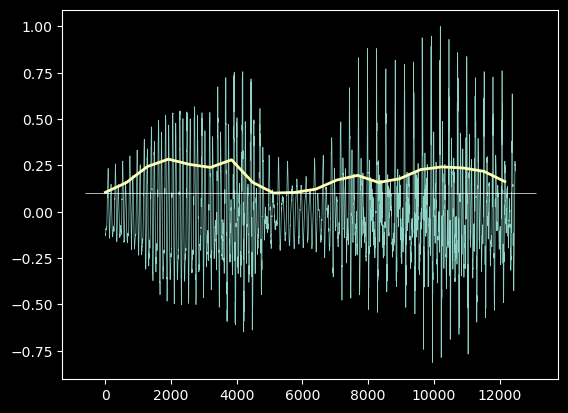

In [21]:
reload(tools)
plt.plot(x)
plt.plot(f_start, [tools.vol(f) for f in frames], linewidth=2)
plt.hlines(0.1, *plt.xlim())
plt.show()


## all words

In [25]:
add_context = False

grouped = {v: [] for v in tools.VOWELS_SV}
segments, vowels_per_segment = tools.segment_by_words(words, audio, Fs, tools.VOWELS_SV)
for w, segment, vowels in zip(words, segments, vowels_per_segment):
    if w["conf"] >= 1:
        # print(w["word"], w["conf"])
        frames, f_start = tools.split_frames(segment, fl, Fs, overlap=0)
        peak_frames, hnr_frames = HNR_short(frames, Fs, len(vowels))
        if len(peak_frames) == len(vowels):
            for i, v in enumerate(vowels):
                if not tools.checkIfWhite(frames[peak_frames[i]]):
                    if add_context:
                        grouped[v].append(
                            tools.stitch_frames(
                                frames[
                                    max(peak_frames[i] - 2, 0) : min(
                                        peak_frames[i] + 2, len(frames)
                                    )
                                ]
                            )
                        )
                    else:
                        grouped[v].append(frames[peak_frames[i]])

audio_out = {}
for v in grouped.keys():
    audio_out[v] = tools.stitch_frames(
        grouped[v], fade_pow=0.7, padding=(Fs / 4) * add_context
    )

    path = f"output/concatenated/concatenated_{v}.wav"
    wavfile.write(path, Fs, audio_out[v])
    # stretch_audio(path, path, 1)


In [23]:
vowels_in_text = {v: 0 for v in tools.VOWELS_SV}
for c in tools.checkVowels(text, tools.VOWELS_SV):
    vowels_in_text[c] += 1

print("found vowels:")
for v in grouped.keys():
    print(
        "    ",
        v,
        len(grouped[v]),
        str(round(100 * len(grouped[v]) / vowels_in_text[v], 3)) + "%",
    )

found vowels:
     y 36 55.385%
     å 168 68.016%
     u 158 68.103%
     i 361 63.668%
     e 752 64.605%
     ö 133 71.892%
     a 757 69.069%
     o 330 68.041%
     ä 155 60.078%


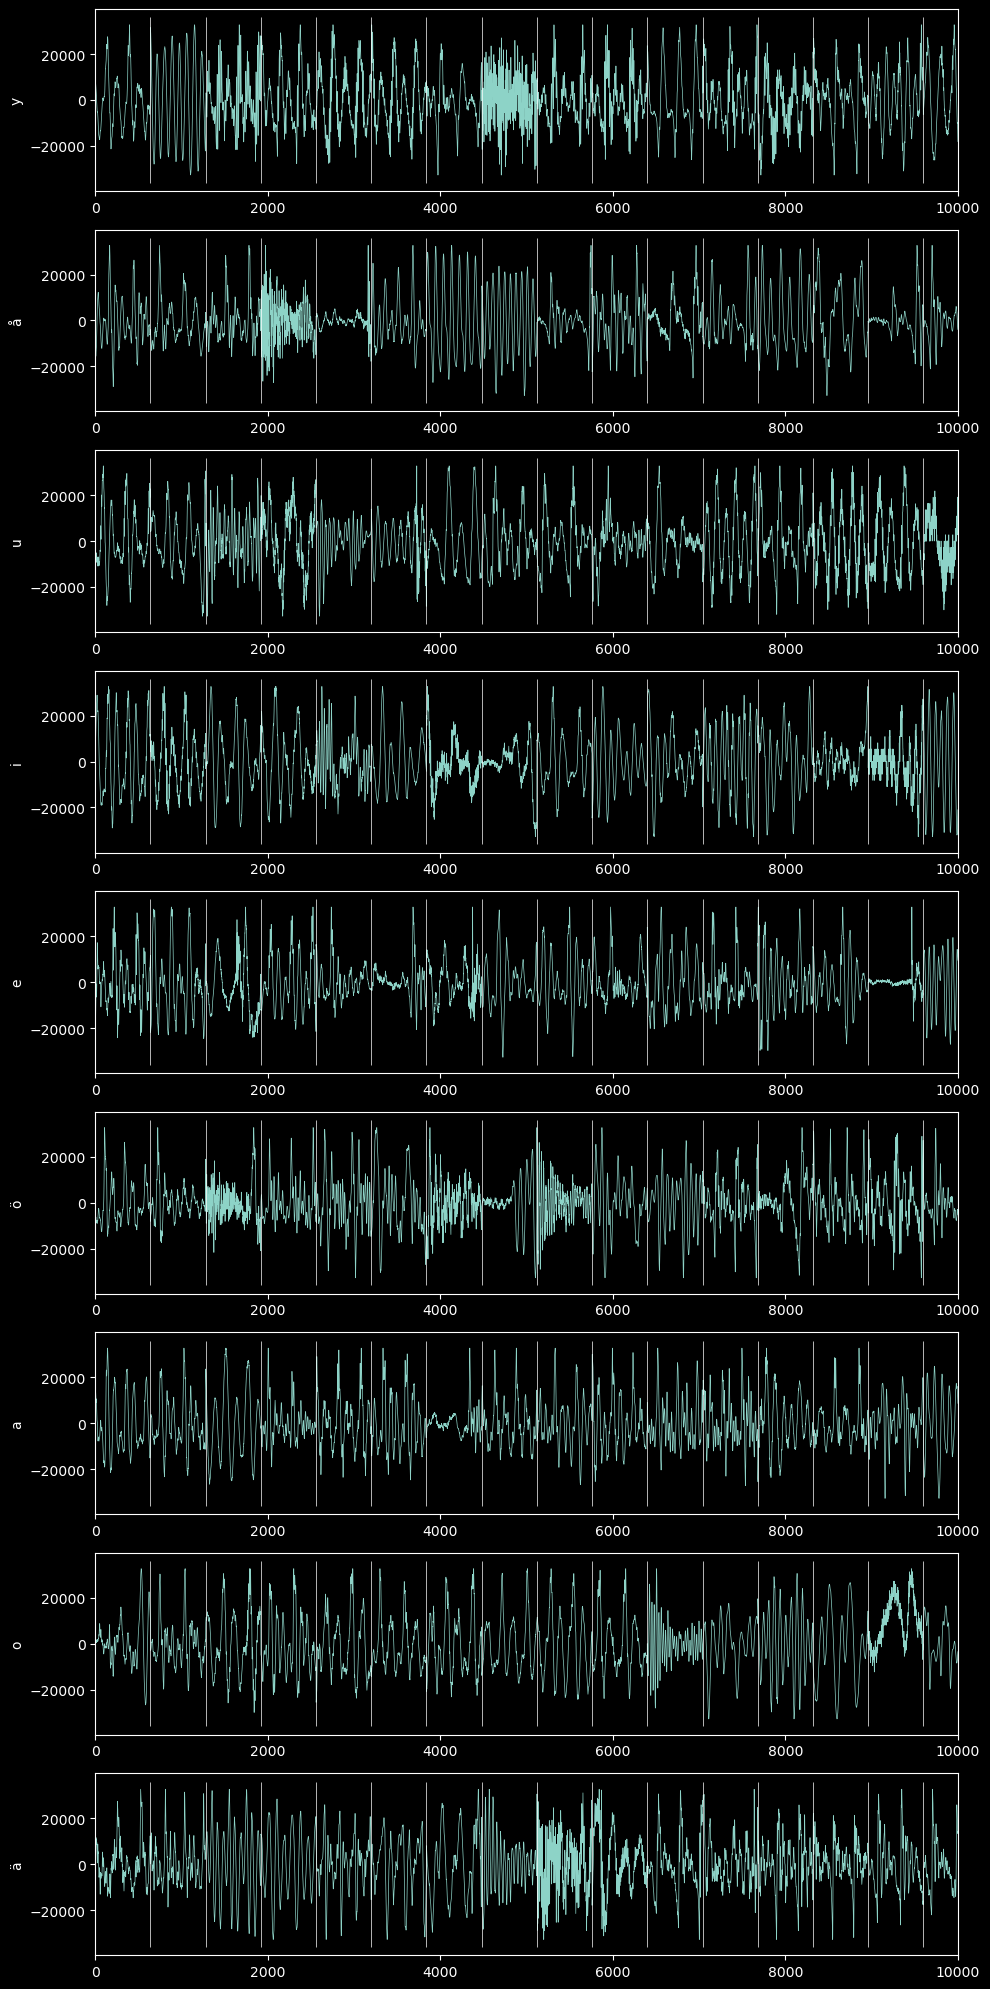

In [24]:
plt.figure(figsize=((10, 20)))
for i, v in enumerate(audio_out.keys()):
    plt.subplot(len(tools.VOWELS_SV), 1, i + 1)
    plt.plot(audio_out[v])
    plt.xlim(0, 10000)
    plt.vlines(np.arange(0, len(audio_out[v]), fl), *plt.ylim())
    plt.ylabel(v)

plt.tight_layout()